In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import mnist,fashion_mnist
import cv2
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Conv2D,Dense,GlobalAveragePooling2D,MaxPooling2D,Dropout,Input
from tensorflow.keras.models import Model

In [10]:
class Siamese:

    @staticmethod
    def build_siamese_model(inputShape, embeddingDim=48):
        # Specify the inputs for the feature extractor network
        inputs = Input(inputShape)
        # Define the first set of CONV => RELU => POOL => DROPOUT layers
        x = Conv2D(64, (2, 2), padding="same")(inputs)
        x=layers.Lambda(lambda t:tf.maximum(0.0,t))(x)        # Relu
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.3)(x)
        # Second set of CONV => RELU => POOL => DROPOUT layers
        x = Conv2D(64, (2, 2), padding="same")(x)
        x=layers.Lambda(lambda t:tf.maximum(0.0,t))(x)        # RElu
        x = MaxPooling2D(pool_size=2)(x)
        x = Dropout(0.3)(x)
        # Prepare the final outputs
        pooledOutput = GlobalAveragePooling2D()(x)
        outputs = Dense(embeddingDim)(pooledOutput)
        # Build the model
        model = Model(inputs, outputs)
        # Return the model to the calling function
        return model
    @staticmethod
    def make_pairs(images, labels):
        # Initialize two empty lists to hold the (image, image) pairs and
        # labels to indicate if a pair is positive or negative
        pairImages = []
        pairLabels = []
        # Calculate the total number of classes present in the dataset and then build a list of indexes
        # for each class label that provides the indexes for all examples with a given label
        numClasses = len(np.unique(labels))
        idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
        # Loop over all images
        for idxA in range(len(images)):
            # Grab the current image and label belonging to the current iteration
            currentImage = images[idxA]
            label = labels[idxA]
            # Randomly pick an image that belongs to the *same* class label
            idxB = np.random.choice(idx[label])
            posImage = images[idxB]
            # Prepare a positive pair and update the images and labels lists, respectively
            pairImages.append([currentImage, posImage])
            pairLabels.append([1])
            # Grab the indices for each of the class labels *not* equal to the current label and randomly pick an image
            # corresponding to a label *not* equal to the current label
            negIdx = np.where(labels != label)[0]
            negImage = images[np.random.choice(negIdx)]
            # Prepare a negative pair of images and update our lists
            pairImages.append([currentImage, negImage])
            pairLabels.append([0])
        # Return a 2-tuple of the image pairs and labels
        return np.array(pairImages), np.array(pairLabels)

    @staticmethod
    def euclidean_distance(vectors):

        (featsA, featsB) = vectors

        return tf.math.reduce_euclidean_norm(featsA - featsB, axis = 1, keepdims = True)
        

    @staticmethod
    def plot_training(H):
        # Construct a plot that plots and saves the training history
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.legend()
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")

In [3]:
class ContrastiveLoss(Loss):
    def __init__(self,margin):
        super().__init__()
        self.margin=margin
    def call(self,y_true,y_pred):
        y_true=tf.cast(y_true,y_pred.dtype)
        squaredPreds=tf.square(y_pred)
        squaredMargin=tf.square(tf.maximum(self.margin-y_pred,0))
        loss=tf.reduce_mean(y_true*squaredPreds+(1-y_pred)*squaredMargin)
        return loss

In [4]:
(trainX,trainY),(testX,testY)=fashion_mnist.load_data()
trainX=trainX/255.0
testX=testX/255.0
trainX=np.expand_dims(trainX,axis=-1)
testX=np.expand_dims(testX,axis=-1)
pairImages=[]
pairLabels=[]

In [5]:
(pairTrain, labelTrain) = Siamese.make_pairs(trainX, trainY)
(pairTest, labelTest) = Siamese.make_pairs(testX, testY)

In [6]:
IMG_SHAPE = (28, 28, 1)
imgA=layers.Input(IMG_SHAPE)
imgB=layers.Input(IMG_SHAPE)
featureExtractor=Siamese.build_siamese_model(IMG_SHAPE)
featsA=featureExtractor(imgA)
featsB=featureExtractor(imgB)
distance=layers.Lambda(Siamese.euclidean_distance)([featsA,featsB])
#outputs=Dense(1,activation='sigmoid')(distance)   # for classification
model = models.Model(inputs=[imgA, imgB], outputs=distance)

In [7]:
model.compile(loss=ContrastiveLoss(1),optimizer="adam")

In [8]:
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain,
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest),
                    batch_size=64, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 53s 26ms/step - loss: 0.2317 - val_loss: 0.3492
Epoch 2/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2212 - val_loss: 0.3707
Epoch 3/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2193 - val_loss: 0.3522
Epoch 4/20
1875/1875 [==============================] - 50s 26ms/step - loss: 0.2180 - val_loss: 0.3368
Epoch 5/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2170 - val_loss: 0.3353
Epoch 6/20
1875/1875 [==============================] - 50s 26ms/step - loss: 0.2163 - val_loss: 0.3356
Epoch 7/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2160 - val_loss: 0.3197
Epoch 8/20
1875/1875 [==============================] - 50s 26ms/step - loss: 0.2154 - val_loss: 0.3143
Epoch 9/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2150 - val_loss: 0.3116
Epoch 10/20
1875/1875 [==============================] - 50s 27m

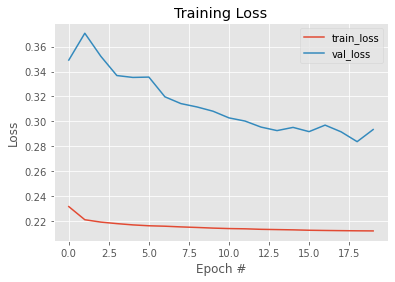

In [11]:
Siamese.plot_training(history)